# Simulate Polarised Cold Clumps (SPoCC) for PySM3 Galactic dust models

#### Import Modules

In [76]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import pylab as pl
from pathlib import Path
from astropy import constants as const, units as u 
from time import time

### Analyse the Original Planck Galactic Cold Clump Catalogue

Here we just show a quick visualisation of the key parameters for the cold clumps as given by the Planck Galactic cold clump catalogue released in 2015. Before plotting the distributions of key parameters, we have to make some cuts to the catalogue to restrict the sources to `flux_density == 1` which restricts the sources to those measured with high signal to noise in all three Planck frequencies AND the IRIS 3 THz band. We also restrict to sources without the `flux_blending` flag which describes sources that have overlap and hence less reliable fits.

In [4]:
PGCC_df = pd.read_csv('/global/homes/j/justinc/SO_Galactic_Cold_Clumps/PGCC.csv')
PGCC_df = PGCC_df[PGCC_df.flux_quality == 1]
PGCC_df = PGCC_df[PGCC_df.flux_blending == 0]
PGCC_df = PGCC_df.reset_index(drop = True)
Ns = len(PGCC_df) # Number of objects remaining

# Save the key parameters
Params = {
    'glon'              : PGCC_df.glon,               # Galactic Longitude
    'glat'              : PGCC_df.glat,               # Galactic Latitude
    'gau_major_axis'    : PGCC_df.gau_major_axis,     # Major axis size
    'gau_minor_axis'    : PGCC_df.gau_minor_axis,     # Minor axis size
    'gau_position_angle': PGCC_df.gau_position_angle, # Rotation Angle
    'temp_clump'        : PGCC_df.temp_clump,         # Dust Temperature
    'beta_clump'        : PGCC_df.beta_clump,         # Spectral Index
    'flux_353_clump'    : PGCC_df.flux_353_clump,     # Reference flux
}

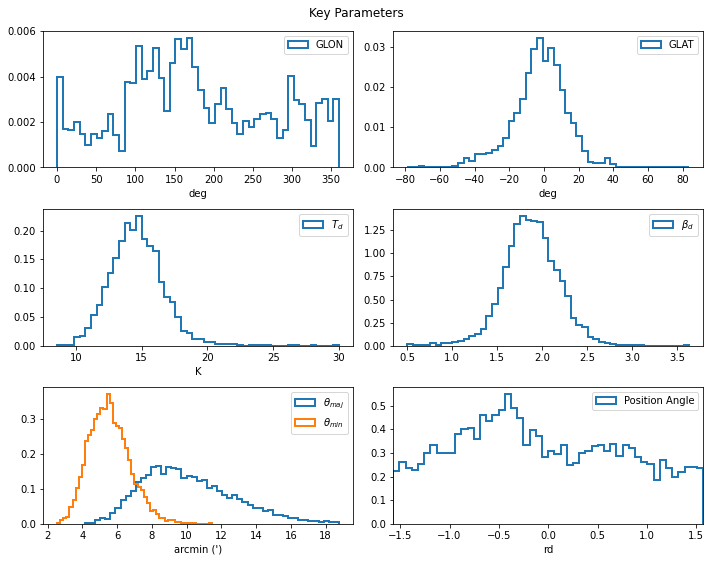

In [14]:
gs = gridspec.GridSpec(4,2)
plt.figure(figsize = (10,10))
kwargs = {'bins':50,'density':True,'histtype':'step','linewidth':2}
plt.suptitle('Key Parameters')
ax = plt.subplot(gs[0,0])
glon_h = plt.hist(Params['glon'], 
                                **kwargs, label = 'GLON')
ax.set_xlabel('deg')
ax.legend()
ax = plt.subplot(gs[0,1])
glat_h = plt.hist(Params['glat'], 
                                **kwargs, label = 'GLAT')
ax.set_xlabel('deg')
ax.legend()
ax = plt.subplot(gs[1,0])
Td_h = plt.hist(Params['temp_clump'], 
                            **kwargs, label = '$T_{d}$')
ax.set_xlabel('K')
ax.legend()
ax = plt.subplot(gs[1,1])
Bd_h = plt.hist(Params['beta_clump'], 
                            **kwargs, label = '$\\beta_{d}$')
ax.set_xlabel('')
ax.legend()
ax = plt.subplot(gs[2, 0])
tmaj_h = plt.hist(Params['gau_major_axis'], 
                                **kwargs, label = '$\\theta_{maj}$')
tmin_h = plt.hist(Params['gau_minor_axis'], 
                                **kwargs, label = '$\\theta_{min}$')
ax.set_xlabel("arcmin (')")
ax.legend()
ax = plt.subplot(gs[2, 1])
PA_h = plt.hist(Params['gau_position_angle'], 
                            **kwargs, label = 'Position Angle')
ax.set_xlim(-1.5708, 1.5708)
ax.set_xlabel("rd")
ax.legend()
plt.tight_layout()
plt.show()

We want to save the histogram data to sample the distributions. Note each parameter here will contain the value of the histogram bins and the bin edges.

In [20]:
Param_Dists = {
    'glon'              : glon_h,               # Galactic Longitude
    'glat'              : glat_h,               # Galactic Latitude
    'gau_major_axis'    : tmaj_h,               # Major axis size
    'gau_minor_axis'    : tmin_h,               # Minor axis size
    'gau_position_angle': PA_h,                 # Rotation Angle
    'temp_clump'        : Td_h,                 # Dust Temperature
    'beta_clump'        : Bd_h,                 # Spectral Index
    #'flux_353_clump'    : S_h,                  # Reference flux
}
Param_Dists_Sim = Param_Dists.copy()

### Bootstrap Sample Parameter Distributions


In [16]:
sample_size = 10000

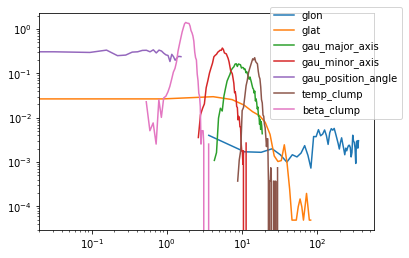

In [19]:
for p in Param_Dists:
    x = Param_Dists[p][1]
    x_bins = 0.5 * (x[1:] + x[:-1])
    Y = Param_Dists[p][0]
    plt.loglog(x_bins, Y, '-', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

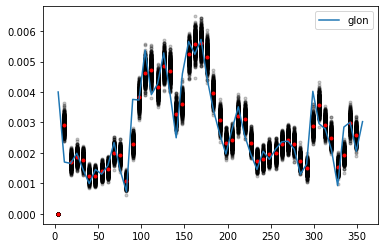

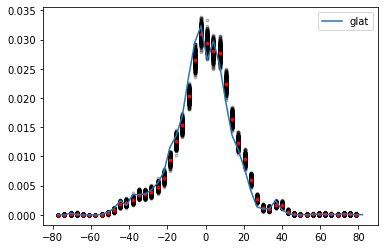

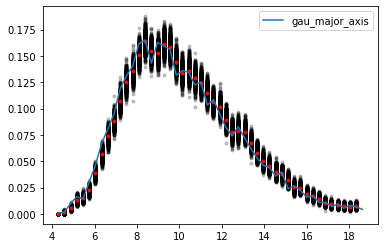

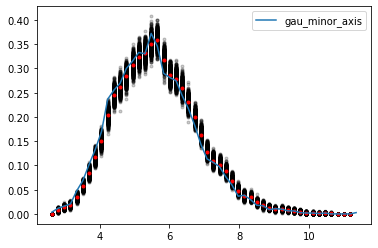

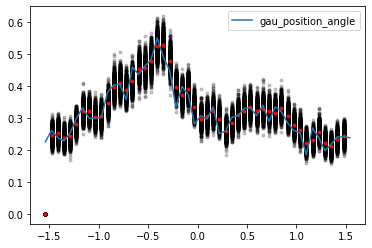

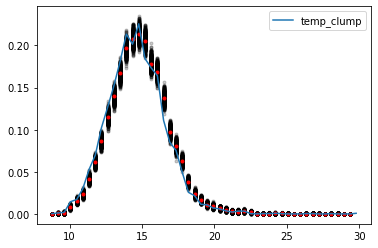

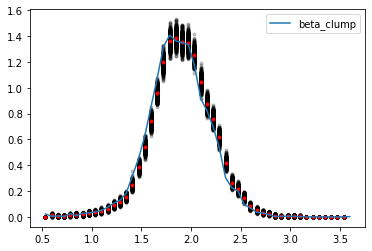

In [26]:
from add_planck_galccs.Sampler import build_sampler_functional
for p in Param_Dists:
    x = Param_Dists[p][1]
    x_bins = 0.5 * (x[1:] + x[:-1])
    Y = Param_Dists[p][0]
    sampler = build_sampler_functional(Y, x_bins)
    norm = np.trapz(Y, x_bins)
    xbs = []
    samples = []
    means, varis, stds = [], [], []
    for i in range(1000):
        z = np.random.uniform(size = sample_size)
        bootstrapped_values = sampler(z)
        bins = np.linspace(x_bins.min(), x_bins.max(), 50)
        h, edge = np.histogram(bootstrapped_values, 
                               bins = bins, density = True)
        xb = [(edge[i] + edge[i]) * 0.5 for i in range(edge.shape[0] - 1)]
        plt.plot(xb, h * norm, 'k.', alpha = 0.2)
        samples.append(h*norm)
        mean = np.average(np.array(xb), weights = h * norm)
        var  = np.average((np.array(xb) - mean) ** 2, weights = h * norm)
        std  = np.sqrt(var)
        means.append(mean)
        varis.append(var)
        stds.append(std)
    newdata = np.mean(samples, axis = 0)
    Param_Dists_Sim[p] = [np.mean(means), np.mean(varis), np.mean(stds)]
    plt.plot(xb, newdata, 'r.')
    plt.plot(x_bins, Y, label = p)
    plt.legend()
    plt.show()

### Polarisation Fraction
The mean and uncertainty of the polarisation fraction has been obtained by stacking all sources in the above dataframe then bootstrapping the stack 10,000 times to obtain the result
\begin{equation}
\langle\Pi\rangle = 0.038522\pm0.000531
\end{equation}
We will (as with all parameters aside from the Position angle, Galactic Longitude and polarisation angle - which are all uniform distributions) assume this to follow a Gaussian distribution. 

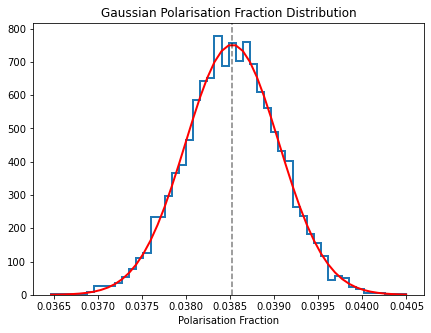

In [33]:
PFmu = 0.038522081196633695
PFsig = 0.0005307579803816133
sPFrac = np.random.normal(PFmu, PFsig, len(PGCC_df))
plt.figure(figsize = (7,5))
count, bins, _ = plt.hist(sPFrac, **kwargs)
plt.plot(bins, 1 / (PFsig * np.sqrt(2 * np.pi)) * np.exp(-(bins-PFmu)**2 / (2 * PFsig ** 2)), 
         linewidth = 2, color = 'r')
plt.title('Gaussian Polarisation Fraction Distribution')
plt.xlabel('Polarisation Fraction')
plt.axvline(PFmu, alpha = 0.5, color = 'k', linestyle = '--')
plt.show()


## Simulated Distributions

With this information we are now able to create simulated distributions that we can use to populate a new catalogue of these generated Galactic Cold Clumps

In [66]:
Param_Sims = {}
for p in Param_Dists_Sim:
    if p == 'glon':
        s = np.random.uniform(0, 360, len(PGCC_df))
    elif p == 'gau_position_angle':
        s = np.random.uniform(-1.57079633, 1.57079633, len(PGCC_df))
    else:
        s = np.random.normal(Param_Dists_Sim[p][0], Param_Dists_Sim[p][2],
                             len(PGCC_df))
    Param_Sims[p] = s
Param_Sims['polarisation_angle'] = np.random.uniform(-1.57079633, 1.57079633, len(PGCC_df))
Param_Sims['polarisation_fraction'] = sPFrac

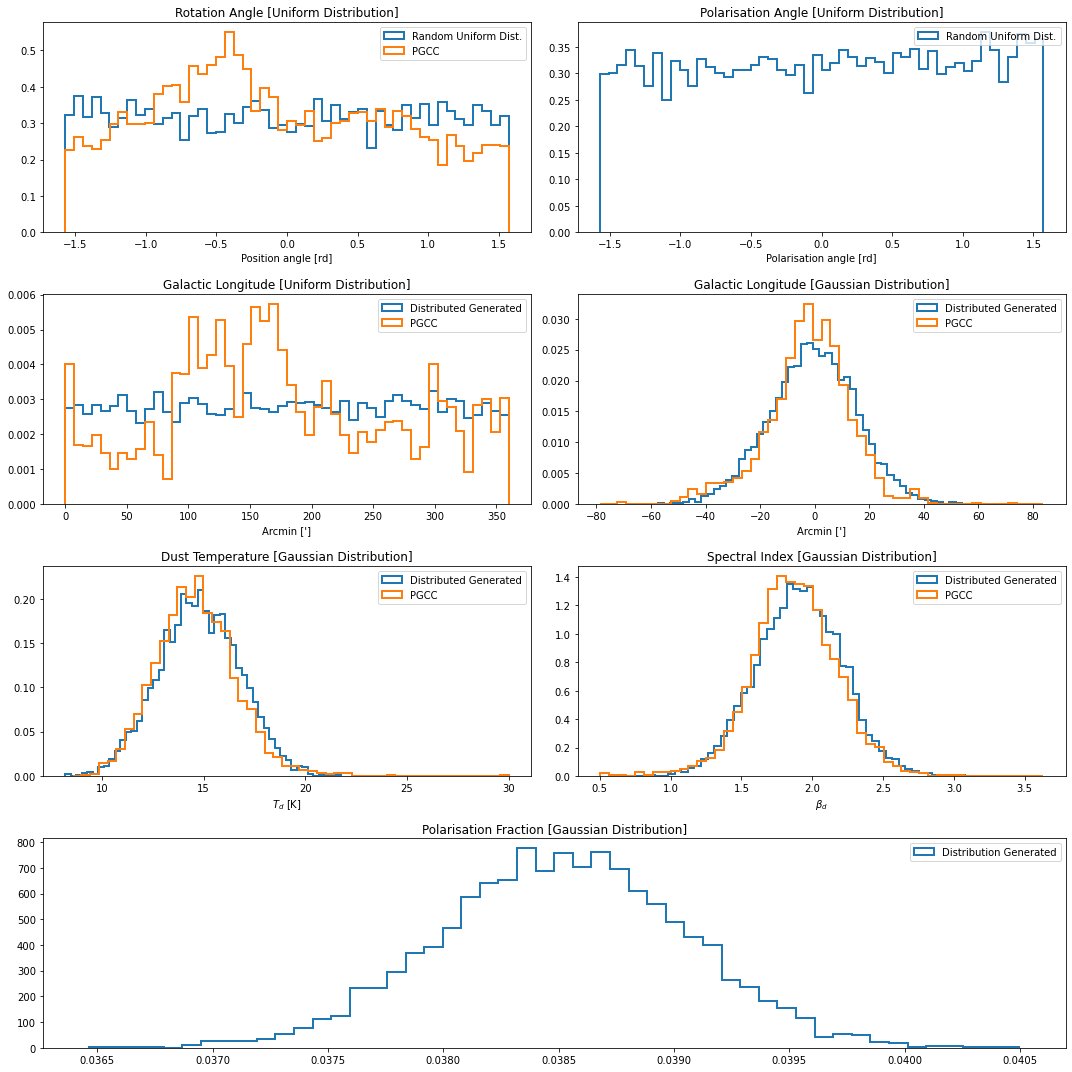

In [67]:
gs = gridspec.GridSpec(4,2)
plt.figure(figsize = (15,15))

ax=plt.subplot(gs[0,0])
p = 'gau_position_angle'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Random Uniform Dist.')
plt.hist(Params[p], **kwargs, 
         label = 'PGCC')
ax.set_title('Rotation Angle [Uniform Distribution]')
ax.set_xlabel('Position angle [rd]')
ax.legend()

ax=plt.subplot(gs[0,1])
p = 'polarisation_angle'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Random Uniform Dist.')
ax.set_title('Polarisation Angle [Uniform Distribution]')
ax.set_xlabel('Polarisation angle [rd]')
ax.legend()

ax=plt.subplot(gs[1,0])
p = 'glon'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Distributed Generated')
plt.hist(Params[p], **kwargs, 
         label = 'PGCC')
ax.set_title('Galactic Longitude [Uniform Distribution]')
ax.set_xlabel("Arcmin [']")
ax.legend()

ax=plt.subplot(gs[1,1])
p = 'glat'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Distributed Generated')
plt.hist(Params[p], **kwargs, 
         label = 'PGCC')
ax.set_title('Galactic Longitude [Gaussian Distribution]')
ax.set_xlabel("Arcmin [']")
ax.legend()

ax=plt.subplot(gs[2,0])
p = 'temp_clump'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Distributed Generated')
plt.hist(Params[p], **kwargs, 
         label = 'PGCC')
ax.set_title('Dust Temperature [Gaussian Distribution]')
ax.set_xlabel('$T_d$ [K]')
ax.legend()

ax=plt.subplot(gs[2,1])
p = 'beta_clump'
plt.hist(Param_Sims[p], **kwargs, 
         label = 'Distributed Generated')
plt.hist(Params[p], **kwargs, 
         label = 'PGCC')
ax.set_title('Spectral Index [Gaussian Distribution]')
ax.set_xlabel('$\\beta_d$')
ax.legend()

ax = plt.subplot(gs[3, :])
plt.hist(Param_Sims['polarisation_fraction'], 
         **kwargs, label = 'Distribution Generated')
ax.set_title('Polarisation Fraction [Gaussian Distribution]')
ax.set_xlabel('')
ax.legend()
plt.tight_layout()
plt.show()

Equivalently this data is now in a dataframe that we can save as a simulated catalogue of Galactic cold clumps

In [70]:
simulated_catalogue = pd.DataFrame(Param_Sims)
display(simulated_catalogue[:5])
simulated_catalogue.to_csv('SimPGCC.csv')

,glon,glat,gau_major_axis,gau_minor_axis,gau_position_angle,temp_clump,beta_clump,polarisation_angle,polarisation_fraction
0,284.491226,11.242278,10.012450,4.823371,-0.554232,14.852721,2.097016,1.514284,0.038854
1,109.347907,-4.130301,11.528708,5.518548,0.791096,13.366334,1.767464,0.207244,0.038134
2,254.833562,7.965647,9.356174,6.755685,-1.553094,15.654752,2.045538,-0.284943,0.039265
3,191.231434,-0.163703,10.974412,3.834076,1.287595,16.805076,1.590076,-0.743334,0.039198
4,28.861923,-14.378761,7.806703,7.190875,1.275378,13.174201,1.908191,-0.050315,0.039227


## Build Simulated Galactic Cold Clump maps

#### !!!
Please note: Number counts are yet to be added to simulate flux density, this is required for the catalogue to work in the below function. Also need to figure out how to decompose from Polarisation Fraction back down into Q & U maps

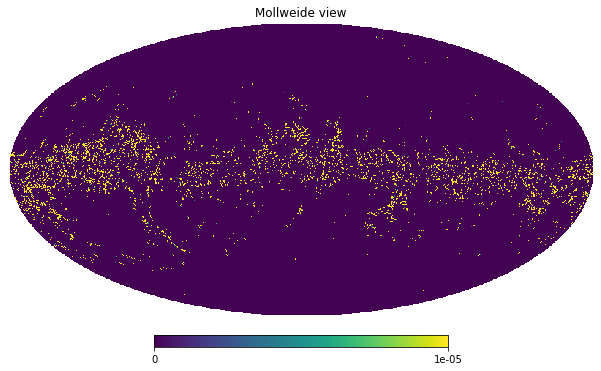

In [77]:
from SPoCC.generate_galcc_maps import build_galactic_clump_map

base_map = build_galactic_clump_map(nside = 2048, catalogue = 'PGCC.csv')
galccmap = base_map.cold_clumps_flux(freq_out = 353, output_units = u.MJy/u.sr)
hp.mollview(galccmap, min = 0, max = 0.00001)

### Mask Sources

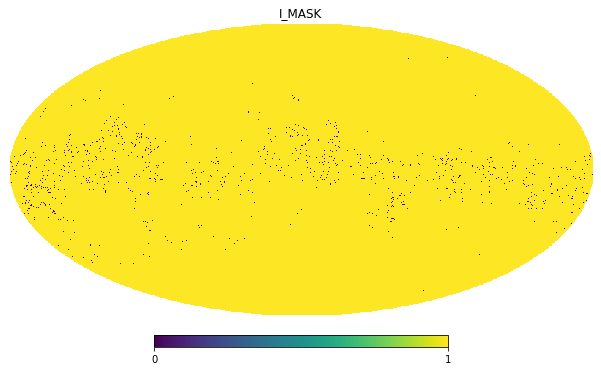

In [78]:
source_mask = base_map.mask_sources(threshold = 1e-1)
hp.mollview(source_mask, title = 'I_MASK')